In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# LSTM1

In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 87555 (342.01 KB)
Trainable params: 87555 (342.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 14s 50ms/step - loss: 1.0582 - accuracy: 0.4335 - val_loss: 0.9792 - val_accuracy: 0.5487
Epoch 2/10
26/26 [==============================] - 1s 26ms/step - loss: 0.8908 - accuracy: 0.5619 - val_loss: 0.7405 - val_accuracy: 0.6592
Epoch 3/10
26/26 [==============================] - 1s 20ms/step - loss: 0.7200 - accuracy: 0.6539 - val_loss: 0.6087 - val_accuracy: 0.7606
Epoch 4/10
26/26 [==============================] - 1s 23ms/step - loss: 0.5355 - accuracy: 0.7760 - val_loss: 0.3396 - val_accuracy: 0.8925
Epoch 5/10
26/26 [==============================] - 1s 23ms/step - loss: 0.4008 - accuracy: 0.8721 - val_loss: 0.4725 - val_accuracy: 0.8661
Epoch 6/10
26/26 [==============================] - 1s 20ms/step - loss: 0.3451 - accuracy: 0.8919 - val_loss: 0.1171 - val_accuracy: 0.9635
Epoch 7/10
26/26 [==============================] - 1s 20ms/step - loss: 0.1235 - accuracy: 0.9623 - val_loss: 0.0482 - val_accuracy: 0.9848
Epoch 8/10
2

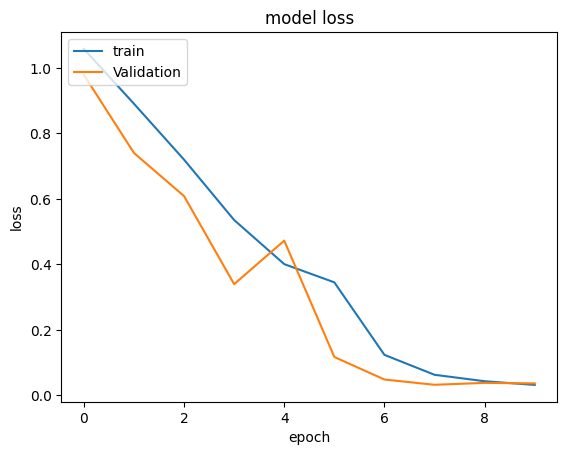

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

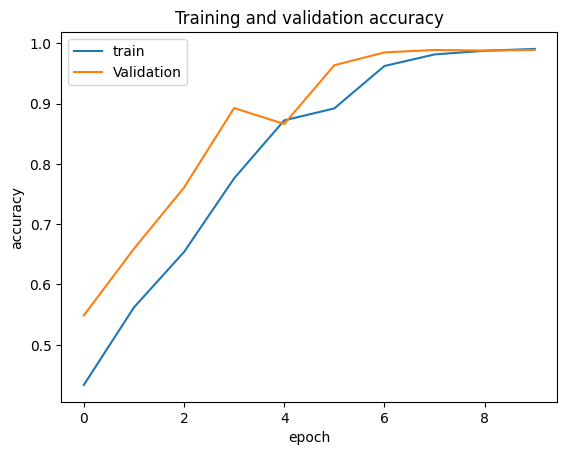

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 5ms/step
[[399  54  43]
 [  5 455  11]
 [  1   0 419]]
0.9178082191780822
0.9162132940689531
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       496
           1       0.89      0.97      0.93       471
           2       0.89      1.00      0.94       420

    accuracy                           0.92      1387
   macro avg       0.92      0.92      0.92      1387
weighted avg       0.92      0.92      0.92      1387



<Axes: >

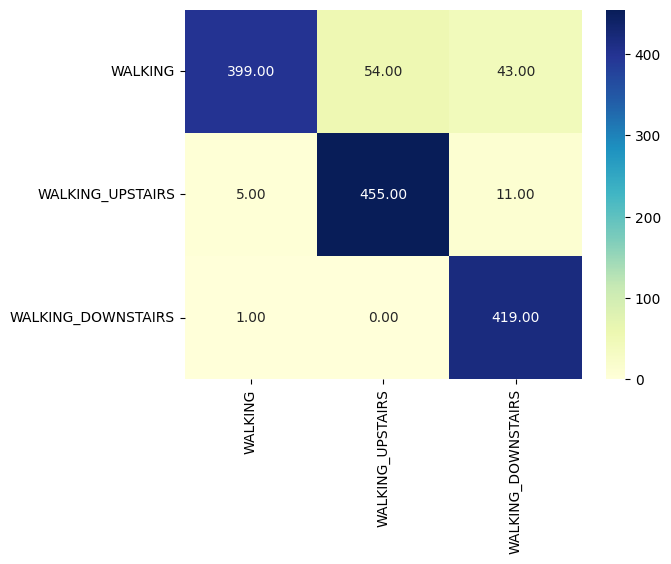

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM 2


In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 219139 (856.01 KB)
Trainable params: 219

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 7s 60ms/step - loss: 1.0003 - accuracy: 0.4910 - val_loss: 0.8359 - val_accuracy: 0.6258
Epoch 2/10
26/26 [==============================] - 1s 22ms/step - loss: 0.6853 - accuracy: 0.7257 - val_loss: 0.4377 - val_accuracy: 0.8408
Epoch 3/10
26/26 [==============================] - 1s 24ms/step - loss: 0.4151 - accuracy: 0.8578 - val_loss: 0.3138 - val_accuracy: 0.8945
Epoch 4/10
26/26 [==============================] - 1s 28ms/step - loss: 0.3038 - accuracy: 0.8986 - val_loss: 0.1985 - val_accuracy: 0.9381
Epoch 5/10
26/26 [==============================] - 1s 35ms/step - loss: 0.2827 - accuracy: 0.9096 - val_loss: 0.1426 - val_accuracy: 0.9625
Epoch 6/10
26/26 [==============================] - 1s 32ms/step - loss: 0.1689 - accuracy: 0.9516 - val_loss: 0.0769 - val_accuracy: 0.9807
Epoch 7/10
26/26 [==============================] - 1s 27ms/step - loss: 0.1308 - accuracy: 0.9638 - val_loss: 0.1352 - val_accuracy: 0.9574
Epoch 8/10
26

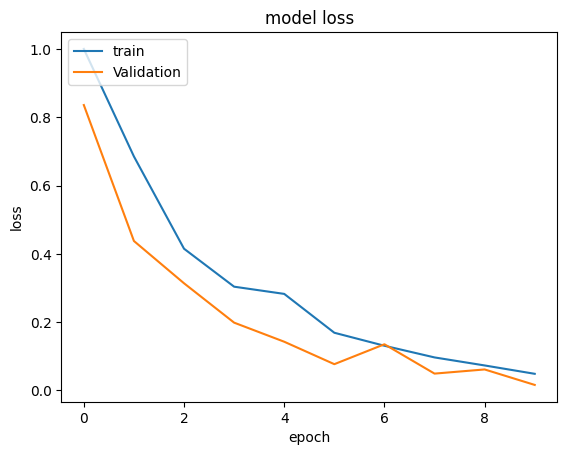

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

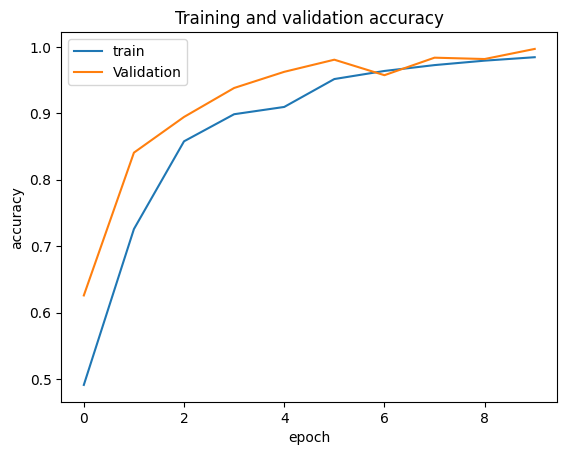

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 9ms/step
[[448  14  34]
 [ 17 436  18]
 [  0   2 418]]
0.9387166546503244
0.9386759539239952
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       496
           1       0.96      0.93      0.94       471
           2       0.89      1.00      0.94       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

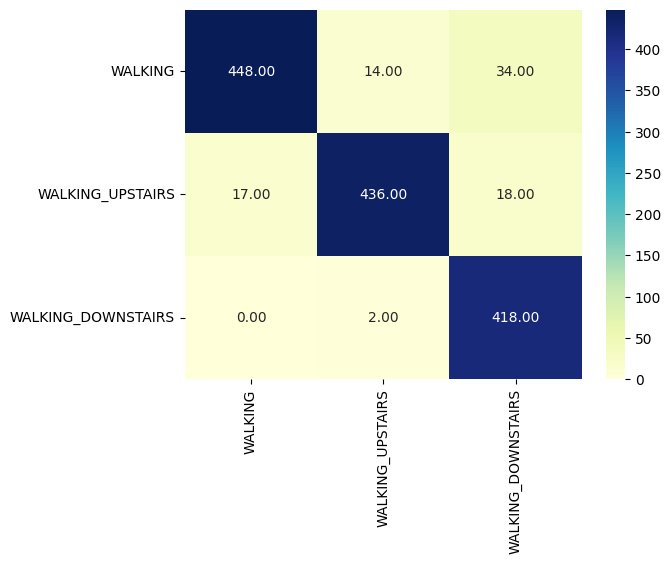

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM 3

In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 10s 103ms/step - loss: 0.9763 - accuracy: 0.5056 - val_loss: 0.7081 - val_accuracy: 0.6968
Epoch 2/10
26/26 [==============================] - 1s 32ms/step - loss: 0.5805 - accuracy: 0.7872 - val_loss: 0.3896 - val_accuracy: 0.8712
Epoch 3/10
26/26 [==============================] - 1s 32ms/step - loss: 0.4190 - accuracy: 0.8633 - val_loss: 0.3545 - val_accuracy: 0.9108
Epoch 4/10
26/26 [==============================] - 1s 32ms/step - loss: 0.2157 - accuracy: 0.9419 - val_loss: 0.1286 - val_accuracy: 0.9625
Epoch 5/10
26/26 [==============================] - 1s 34ms/step - loss: 0.1102 - accuracy: 0.9680 - val_loss: 0.0776 - val_accuracy: 0.9787
Epoch 6/10
26/26 [==============================] - 1s 31ms/step - loss: 0.0751 - accuracy: 0.9772 - val_loss: 0.0419 - val_accuracy: 0.9828
Epoch 7/10
26/26 [==============================] - 1s 34ms/step - loss: 0.0396 - accuracy: 0.9887 - val_loss: 0.0160 - val_accuracy: 0.9939
Epoch 8/10


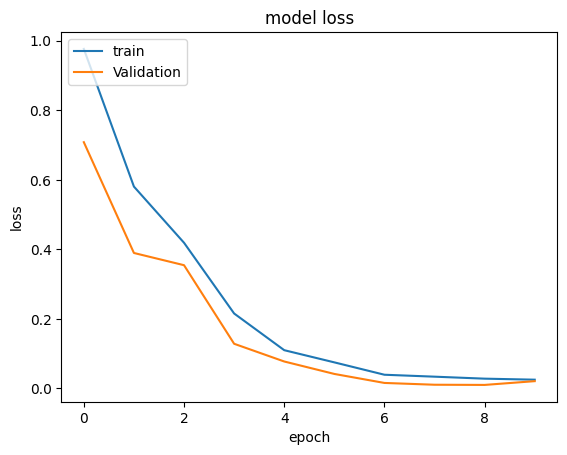

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

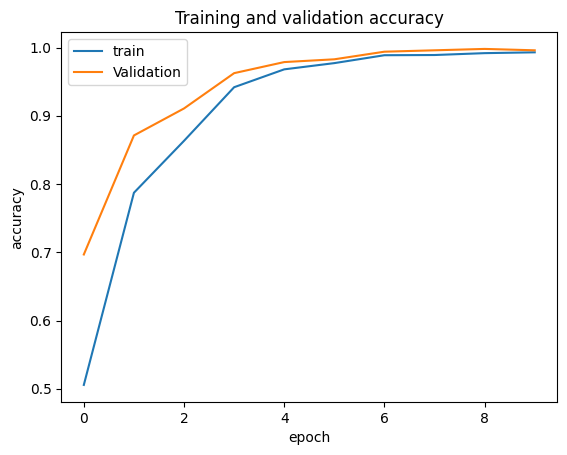

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 10ms/step
[[457   9  30]
 [  7 441  23]
 [  0   0 420]]
0.9502523431867339
0.9505129749675778
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.98      0.94      0.96       471
           2       0.89      1.00      0.94       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

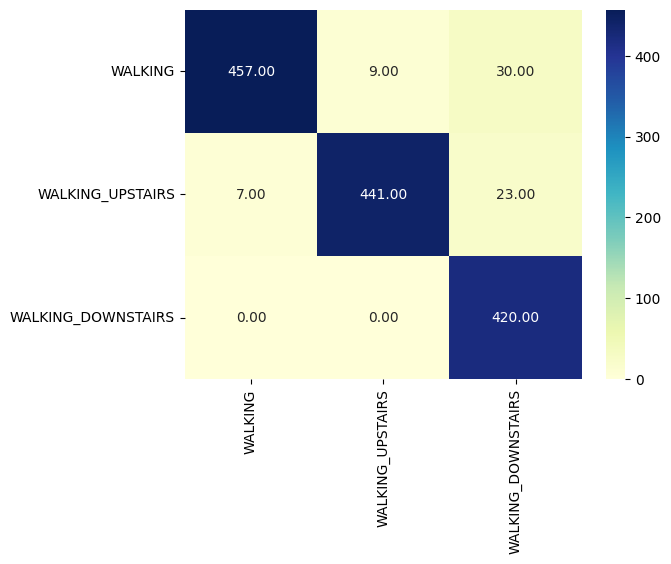

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM 4

In [ ]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 128)          70656     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 12s 107ms/step - loss: 1.0134 - accuracy: 0.4545 - val_loss: 0.9528 - val_accuracy: 0.4635
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.7687 - accuracy: 0.6393 - val_loss: 0.5625 - val_accuracy: 0.7495
Epoch 3/10
26/26 [==============================] - 1s 42ms/step - loss: 0.5126 - accuracy: 0.8186 - val_loss: 0.2647 - val_accuracy: 0.9351
Epoch 4/10
26/26 [==============================] - 1s 42ms/step - loss: 0.2572 - accuracy: 0.9257 - val_loss: 0.2407 - val_accuracy: 0.8935
Epoch 5/10
26/26 [==============================] - 1s 44ms/step - loss: 0.1491 - accuracy: 0.9592 - val_loss: 0.0738 - val_accuracy: 0.9797
Epoch 6/10
26/26 [==============================] - 1s 45ms/step - loss: 0.1102 - accuracy: 0.9750 - val_loss: 0.1696 - val_accuracy: 0.9625
Epoch 7/10
26/26 [==============================] - 1s 45ms/step - loss: 0.1085 - accuracy: 0.9699 - val_loss: 0.1021 - val_accuracy: 0.9635
Epoch 8/10


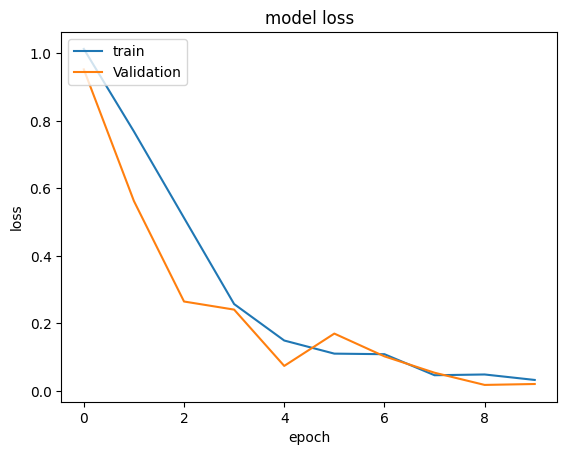

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

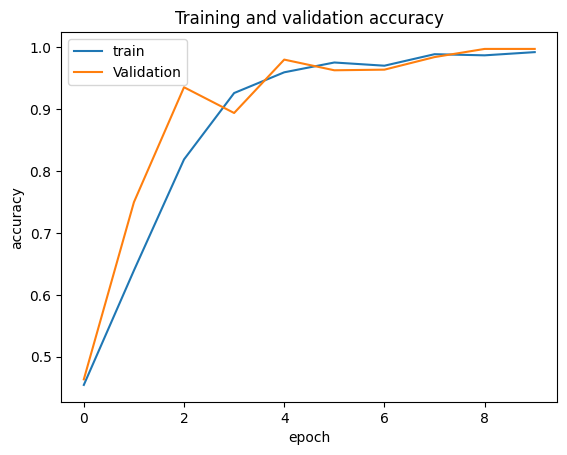

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 12ms/step
[[464  32   0]
 [ 12 447  12]
 [  0   0 420]]
0.9596250901225667
0.9595296478866752
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       496
           1       0.93      0.95      0.94       471
           2       0.97      1.00      0.99       420

    accuracy                           0.96      1387
   macro avg       0.96      0.96      0.96      1387
weighted avg       0.96      0.96      0.96      1387



<Axes: >

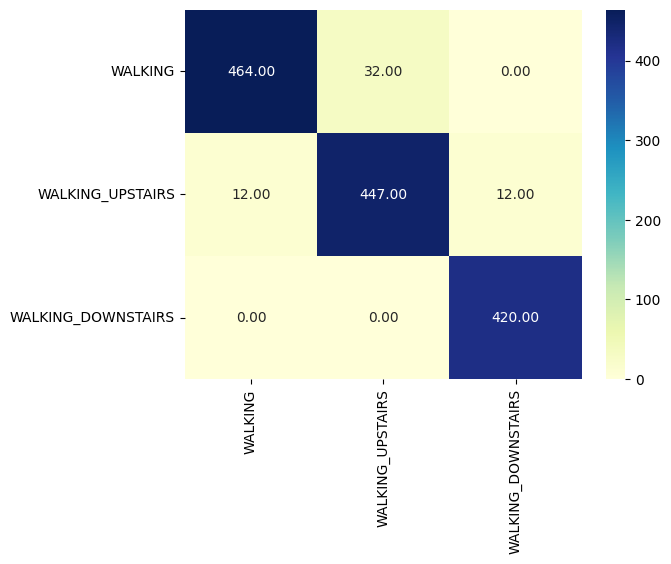

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [16]:
# Model 1
model = Sequential()
model.add(LSTM(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          70656     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128, 128)          1

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 15s 119ms/step - loss: 0.9358 - accuracy: 0.5385 - val_loss: 0.7385 - val_accuracy: 0.7069
Epoch 2/10
26/26 [==============================] - 1s 50ms/step - loss: 0.6576 - accuracy: 0.7513 - val_loss: 0.4644 - val_accuracy: 0.8387
Epoch 3/10
26/26 [==============================] - 1s 50ms/step - loss: 0.4582 - accuracy: 0.8435 - val_loss: 0.4252 - val_accuracy: 0.8570
Epoch 4/10
26/26 [==============================] - 1s 51ms/step - loss: 0.3496 - accuracy: 0.8880 - val_loss: 0.1724 - val_accuracy: 0.9493
Epoch 5/10
26/26 [==============================] - 1s 51ms/step - loss: 0.1538 - accuracy: 0.9568 - val_loss: 0.1569 - val_accuracy: 0.9564
Epoch 6/10
26/26 [==============================] - 1s 51ms/step - loss: 0.1323 - accuracy: 0.9619 - val_loss: 0.0858 - val_accuracy: 0.9817
Epoch 7/10
26/26 [==============================] - 1s 53ms/step - loss: 0.1101 - accuracy: 0.9714 - val_loss: 0.0718 - val_accuracy: 0.9787
Epoch 8/10


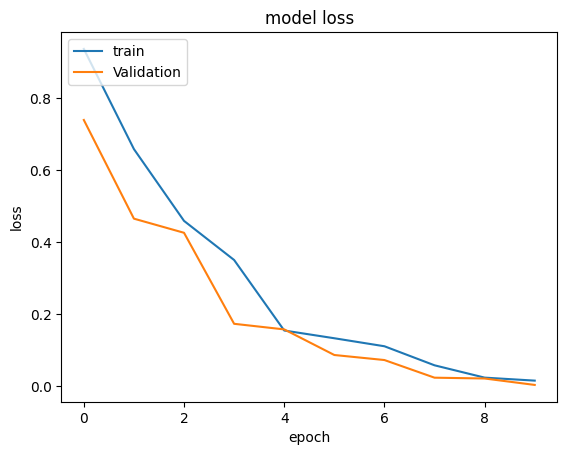

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

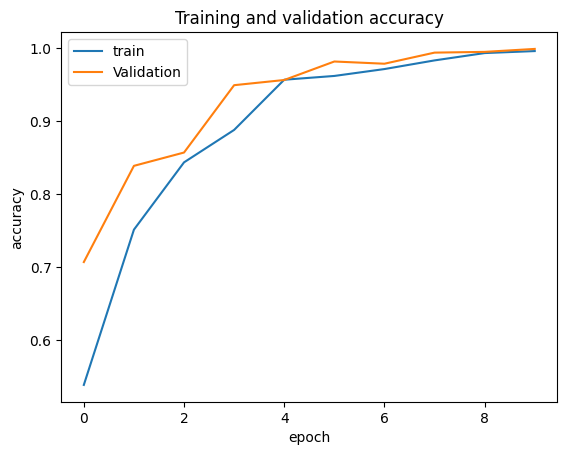

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 14ms/step
[[457  10  29]
 [  7 427  37]
 [  1   0 419]]
0.93943763518385
0.9398968995069058
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.98      0.91      0.94       471
           2       0.86      1.00      0.93       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

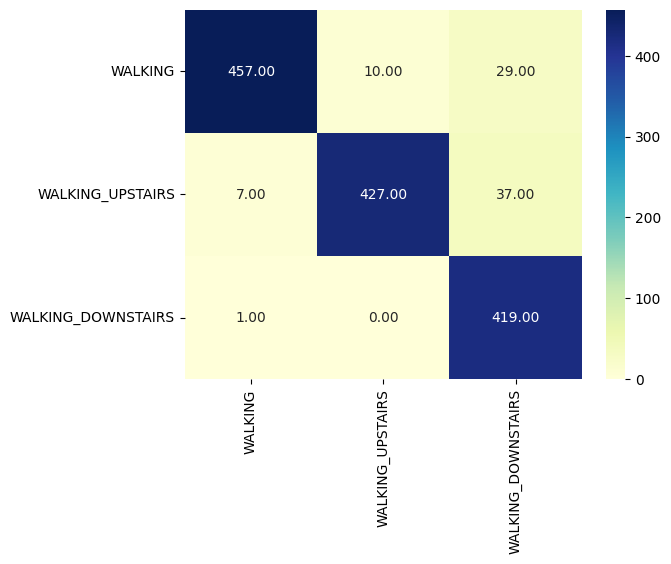

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')